In [1]:
# Fix for issue loading Utils.preprocess_util
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from Utils.preprocess_util import *
from Utils.visualize import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2


In [35]:
person_train_valid = np.load('../Data/person_train_valid.npy')
print(person_train_valid.shape)

(2115, 1)


In [9]:
print(np.unique(person_train_valid))

[0. 1. 2. 3. 4. 5. 6. 7. 8.]


In [17]:
a = np.array([1,2,4,5,1,4,1,5])
c = np.argwhere(a==4)

b = np.array([11,21,41,15,11,43,13,56])
print(b[c])

[[41]
 [43]]


In [2]:
X_train,X_valid,X_test,Y_train,Y_valid,Y_test = load_preprocess_eeg_data(person=0,crop=True)


(2115, 22, 1000)
(237, 22, 1000)
Cropping trials
(19750, 22, 500)
After cropping:
Training data: (19750, 22, 500)
Training target: (19750,)
Validation data: (9875, 22, 500)
Validation target: (9875,)
Test data: (6250, 22, 500)
Test target: (6250,)
Person train/validation: (2115,)
Person test: (443, 1)

After cropping:
Training data: (19750, 22, 500)
Training target: (19750,)
Validation data: (9875, 22, 500)
Validation target: (9875,)
Test data: (6250, 22, 500)
Test target: (6250,)
Person train/validation: (2115,)
Person test: (443, 1)



In [3]:
indices = np.random.choice(X_train.shape[0], X_train.shape[0], replace=False)
X_train = X_train[indices]
Y_train = Y_train[indices]





In [96]:
X_train_small = X_train[0:1000]
Y_train_small = Y_train[0:1000]

In [4]:
indices = np.random.choice(X_valid.shape[0], X_valid.shape[0], replace=False)
X_valid = X_valid[indices]
Y_valid = Y_valid[indices]

indices = np.random.choice(X_test.shape[0], X_test.shape[0], replace=False)
X_test = X_test[indices]
Y_test = Y_test[indices]

In [5]:
print(X_train.shape)

(19750, 22, 500)


In [6]:
# create feature and targets tensor for train set
features_train = torch.from_numpy(X_train)
targets_train = torch.from_numpy(Y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set
features_test = torch.from_numpy(X_test)
targets_test = torch.from_numpy(Y_test).type(torch.LongTensor)

features_valid = torch.from_numpy(X_valid)
targets_valid = torch.from_numpy(Y_valid).type(torch.LongTensor)


In [10]:
class LSTMModel(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs,n_layers,droput):
        super(LSTMModel, self).__init__()
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.num_layers = n_layers
        self.lstm = nn.GRU(self.n_inputs, self.n_neurons,self.num_layers) 
        self.droput = nn.Dropout(p=droput)
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
            # (num_layers, batch_size, n_neurons)
            return (torch.zeros(self.num_layers, self.batch_size, self.n_neurons))
            #return torch.nn.init.xavier_uniform_((self.num_layers, self.batch_size, self.n_neurons), gain=1)

    def forward(self, X):
            # transforms X to (n_steps, batch_size, n_inputs)
            X = X.permute(1, 0, 2) 
            self.batch_size = X.size(1)
            self.hidden = self.init_hidden()
            lstm_out, self.hidden= self.lstm(X, self.hidden)
            hidden_out =self.hidden[self.num_layers-1]
            dropout_out = self.droput(hidden_out)
            out = self.FC(dropout_out)

            return out.view(-1, self.n_outputs) # (batch_size, n_output)


In [11]:
batch_size = 50
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(features_train, targets_train)
valid = torch.utils.data.TensorDataset(features_valid, targets_valid)
test = torch.utils.data.TensorDataset(features_test, targets_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

# pprint.pprint(test_loader.dataset.tensors[0].size())


In [12]:
N_STEPS = 500
N_INPUTS = 22
N_NEURONS = 44
N_OUTPUTS = 10
N_EPOCHS = 10
N_LAYERS = 1# This actually corresponds to how many lsts are stacked one above the other
droput = 0
dataiter = iter(train_loader)
images, labels = dataiter.next()
model = LSTMModel(batch_size, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS,N_LAYERS,droput)

# (batch_size, n_steps, n_inputs)
images_modified = images.view(-1, 500, 22)
logits = model(images_modified.float())
print(logits[0:10])

tensor([[-0.0719, -0.1039,  0.0046,  0.1418, -0.0374, -0.0426,  0.0073, -0.0949,
          0.0587,  0.0172],
        [ 0.2233, -0.0788,  0.0676,  0.0081,  0.1216,  0.0130,  0.1451, -0.1264,
          0.3740,  0.1012],
        [-0.1593, -0.0295, -0.0491, -0.1220, -0.0661,  0.1062, -0.0226,  0.1529,
          0.0704,  0.2423],
        [-0.2815, -0.0811, -0.0977,  0.0342, -0.0829,  0.0231, -0.0534,  0.0472,
         -0.0861,  0.1302],
        [-0.1828,  0.0939, -0.1142,  0.1718, -0.0302,  0.0251, -0.0057, -0.1583,
         -0.0432, -0.0495],
        [-0.1070, -0.1643,  0.0447,  0.0151,  0.0173, -0.0335, -0.0579,  0.0302,
          0.0791,  0.0939],
        [-0.1947, -0.0358, -0.2088,  0.2290,  0.0779,  0.0079, -0.0959, -0.1161,
         -0.0375, -0.1907],
        [-0.3672,  0.0984, -0.2005, -0.1235, -0.3256, -0.0364, -0.1644,  0.1563,
         -0.2663,  0.2715],
        [-0.1116, -0.1666, -0.0188,  0.0682,  0.0011, -0.0802,  0.0728,  0.0167,
          0.1884, -0.0537],
        [-0.3106,  

In [14]:
dtype = torch.FloatTensor
n_iters = 10000
num_epochs = int(n_iters / (len(X_train)/batch_size))
model = LSTMModel(batch_size, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS,N_LAYERS,droput)

# Cross Entropy Loss 
loss_fn = nn.CrossEntropyLoss().type(dtype)

# batch GD
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay =0,betas=(0.9, 0.999),amsgrad=False)
optimizer = torch.optim.RMSprop(model.parameters(),lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.1)

# Create RNN
input_dim = 22
seq_dim = 500

train_loss = []
iterations = []
train_acc = []

X_valid_tensor = torch.from_numpy(X_valid.reshape(-1, seq_dim, input_dim))
X_train_tensor = torch.from_numpy(X_train.reshape(-1, seq_dim, input_dim))

print("num_epochs = ", num_epochs)
print("n_iters = ", n_iters)
print("starting training..")

count = 0
num_epochs = 2
print("starting training..")
for epoch in range(num_epochs):
    print("epoch=",epoch)
    # reset hidden states
    
    for i, (signals, labels) in enumerate(train_loader):
        train  = Variable(signals.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
        
        # Clear gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
                
        # Forward propagation
        outputs = model(train.float())
        
        # Calculate softmax and cross entropy loss
        loss = loss_fn(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
                    
        #print("parameters===",list(model.parameters())[0].data)

        count += 1
        train_loss.append(loss.data)
        iterations.append(count)
        if count % 1 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            
            #indices = np.random.choice(X_train.shape[0], 50, replace=False)
            #X_train_tensor = torch.from_numpy(X_train[indices].reshape(-1, seq_dim, input_dim))
            #y_pred_valid = model( X_valid_tensor.float())
            #val_acc = get_accuracy(y_pred_valid, Y_valid,batch_size=X_valid.shape[0])
            
            y_pred_train = model( train.float())
            train_acc = get_accuracy(y_pred_train,labels,batch_size=labels.shape[0])
            
            indices = np.random.choice(X_valid.shape[0], 50, replace=False)
            
            X_valid_tensor = torch.from_numpy(X_valid[indices].reshape(-1, seq_dim, input_dim))
            
            y_pred_valid = model( X_valid_tensor.float())
            val_acc = get_accuracy(y_pred_valid, Y_valid[indices],
            batch_size=50)
            
            #print('Iteration: {}  Loss: {}' .format(count, loss.data))

            print('Iteration: {}  Loss: {}  Train Accuracy: {} Valid Accuracy: {} %'.format(count, loss.data,train_acc,
                                                                                            val_acc))
            #if(train_acc> 35 and val_acc>35):
                #return
            '''
            # Iterate through test dataset
            for signals, labels in valid_loader:
                signals = Variable(signals.view(-1, seq_dim, input_dim))
                #print(signals.shape)
                # Forward propagation
                outputs_valid = model(signals.float())

                # Get predictions from the maximum value
                predicted = torch.max(outputs_valid.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            train_loss.append(loss.data)
            iterations.append(count)
            train_acc.append(accuracy)
            print('Iteration: {}  Loss: {}  Valid Accuracy: {} %'.format(count, loss.data, accuracy))
          '''  
                                   

num_epochs =  25
n_iters =  10000
starting training..
starting training..
epoch= 0
Iteration: 1  Loss: 2.290794849395752  Train Accuracy: 32.0 Valid Accuracy: 26.0 %
Iteration: 2  Loss: 2.2261366844177246  Train Accuracy: 32.0 Valid Accuracy: 34.0 %
Iteration: 3  Loss: 2.122671365737915  Train Accuracy: 38.0 Valid Accuracy: 20.0 %
Iteration: 4  Loss: 1.9809743165969849  Train Accuracy: 42.0 Valid Accuracy: 26.0 %
Iteration: 5  Loss: 1.8483697175979614  Train Accuracy: 36.0 Valid Accuracy: 18.0 %
Iteration: 6  Loss: 1.7019860744476318  Train Accuracy: 34.0 Valid Accuracy: 22.0 %
Iteration: 7  Loss: 1.4710928201675415  Train Accuracy: 36.0 Valid Accuracy: 16.0 %
Iteration: 8  Loss: 1.5434521436691284  Train Accuracy: 32.0 Valid Accuracy: 20.0 %
Iteration: 9  Loss: 1.4732770919799805  Train Accuracy: 30.0 Valid Accuracy: 24.0 %
Iteration: 10  Loss: 1.4128928184509277  Train Accuracy: 32.0 Valid Accuracy: 22.0 %
Iteration: 11  Loss: 1.4343812465667725  Train Accuracy: 34.0 Valid Accuracy: 

Iteration: 97  Loss: 1.3840237855911255  Train Accuracy: 38.0 Valid Accuracy: 18.0 %
Iteration: 98  Loss: 1.3922898769378662  Train Accuracy: 30.0 Valid Accuracy: 32.0 %
Iteration: 99  Loss: 1.3828011751174927  Train Accuracy: 36.0 Valid Accuracy: 20.0 %
Iteration: 100  Loss: 1.3820263147354126  Train Accuracy: 30.0 Valid Accuracy: 26.0 %
Iteration: 101  Loss: 1.3858752250671387  Train Accuracy: 26.0 Valid Accuracy: 26.0 %
Iteration: 102  Loss: 1.414750337600708  Train Accuracy: 26.0 Valid Accuracy: 36.0 %
Iteration: 103  Loss: 1.3853780031204224  Train Accuracy: 32.0 Valid Accuracy: 18.0 %
Iteration: 104  Loss: 1.37367844581604  Train Accuracy: 36.0 Valid Accuracy: 22.0 %
Iteration: 105  Loss: 1.3724114894866943  Train Accuracy: 36.0 Valid Accuracy: 26.0 %
Iteration: 106  Loss: 1.3905689716339111  Train Accuracy: 24.0 Valid Accuracy: 12.0 %
Iteration: 107  Loss: 1.4015023708343506  Train Accuracy: 38.0 Valid Accuracy: 28.0 %
Iteration: 108  Loss: 1.393295407295227  Train Accuracy: 28.

KeyboardInterrupt: 

In [ ]:
X_train_tensor = torch.from_numpy(X_train.reshape(-1, seq_dim, input_dim))
print(X_train_tensor.shape)
y_pred_train = model( X_train_tensor.float())
train_acc = get_accuracy(y_pred_train, Y_train,
    batch_size=len(Y_train))
print('train accuracy:', train_acc)

X_valid_tensor = torch.from_numpy(X_valid.reshape(-1, seq_dim, input_dim))
print(X_valid_tensor.shape)
y_pred_valid = model( X_valid_tensor.float())
val_acc = get_accuracy(y_pred_valid, Y_valid,
    batch_size=len(Y_valid))
print('validation accuracy:', val_acc)

In [ ]:
print(type(loss))

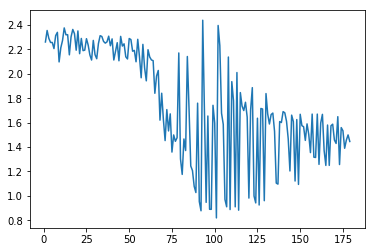

In [37]:
import matplotlib.pyplot as plt
plt.plot(iterations,train_loss)
plt.show();

In [82]:
dtype = torch.FloatTensor
n_iters = 1000
num_epochs = int(n_iters / (len(X_train)/batch_size))

model = LSTMModel(batch_size, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS,N_LAYERS)

# Cross Entropy Loss 
loss_fn = nn.CrossEntropyLoss().type(dtype)

# batch GD
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1,weight_decay = 0, amsgrad=False)

# Create RNN
input_dim = 22
seq_dim = 1000

train_loss = []
iterations = []
train_acc = []

X_valid_tensor = torch.from_numpy(X_valid.reshape(-1, seq_dim, input_dim))
X_train_tensor = torch.from_numpy(X_train.reshape(-1, seq_dim, input_dim))

print("num_epochs = ", num_epochs)
print("n_iters = ", n_iters)
print("starting training..")

count = 0
for epoch in range(num_epochs):
    print("epoch=",epoch)
    # reset hidden states
    model.hidden = model.init_hidden()
    for i, (signals, labels) in enumerate(train_loader):
        train  = Variable(signals.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
        
        # Clear gradients
        optimizer.zero_grad()
        
        # reset hidden states
        #model.hidden = model.init_hidden() 
                
        # Forward propagation
        outputs = model(train.float())
        
        # Calculate softmax and cross entropy loss
        loss = loss_fn(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
                    
        #print("parameters===",list(model.parameters())[0].data)

        count += 1
        train_loss.append(loss.data)
        iterations.append(count
                          
        if count % 1 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            
            
            y_pred_valid = model( X_valid_tensor.float())
            val_acc = get_accuracy(y_pred_valid, Y_valid,batch_size=X_valid.shape[0])
            
            y_pred_train = model( X_train_tensor.float())
            train_acc = get_accuracy(y_pred_train, Y_train,batch_size=X_train.shape[0])
            
            print('Iteration: {}  Loss: {}  Train Accuracy: {} Valid Accuracy: {} %'.format(count, loss.data,train_acc,
                                                                                            val_acc))
            '''
            # Iterate through test dataset
            for signals, labels in valid_loader:
                signals = Variable(signals.view(-1, seq_dim, input_dim))
                #print(signals.shape)
                # Forward propagation
                outputs_valid = model(signals.float())

                # Get predictions from the maximum value
                predicted = torch.max(outputs_valid.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            train_loss.append(loss.data)
            iterations.append(count)
            train_acc.append(accuracy)
            print('Iteration: {}  Loss: {}  Valid Accuracy: {} %'.format(count, loss.data, accuracy))
            '''
                                   

SyntaxError: invalid syntax (<ipython-input-82-e672ddfbaeab>, line 62)

In [40]:
X_valid_tensor = torch.from_numpy(X_valid[0:10000].reshape(-1, seq_dim, input_dim))
print(X_valid_tensor.shape)
y_pred_valid = model( X_valid_tensor.float())
val_acc = get_accuracy(y_pred_valid, Y_valid[0:10000],
    batch_size=10000)
print('validation accuracy:', val_acc)


torch.Size([10000, 500, 22])
validation accuracy: 23.51


In [36]:
X_test_tensor = torch.from_numpy(X_test.reshape(-1, seq_dim, input_dim))
y_pred_test = model( X_test_tensor.float())
test_acc = get_accuracy(y_pred_test, Y_test,
    batch_size=X_test.shape[0])
print('test accuracy:', test_acc)


KeyboardInterrupt: 